In [1]:
# COVID-19 infections per country
# Copyright 2020 Denis Meyer
# Data source: https://github.com/CSSEGISandData/COVID-19

In [2]:
import logging
import io
import requests
import os
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.optimize
import numpy as np

from heapq import nlargest

In [3]:
# Data source
DATA_CONFIRMED_CSV_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
# DATA_DEATHS_CSV_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

# Cache file name
CSV_FILENAME = 'time_series_19-covid-Confirmed-{}.csv'

In [4]:
# Settings

# Ignores file cache if 'True', tries to load data for the current day from file cache otherwise
FORCE_REFRESH_DATA = False
# Ignores all plotting flags and plots (except "all countries")
FORCE_PLOT = True
# Ignores all flags "..._SAVE_PLOT_TO_FILE" and saves to file (except "all countries") - plotting must be activated
FORCE_SAVE_PLOT_TO_FILE = True

# Image path to save the created plot images to (relative to the current directory)
PLOT_IMAGE_PATH = 'images'

# Boolean flag whether to create a plot containing all countries
PLOT_ALL_COUNTRIES = False # May take some time in the current implementation
# Boolean flag whether to save the plot to file
PLOT_ALL_COUNTRIES_SAVE_PLOT_TO_FILE = False

# Boolean flag whether to create a plot containing specific countries
PLOT_SPECIFIC_COUNTRIES = False
# Boolean flag whether to save the plot to file
PLOT_SPECIFIC_COUNTRIES_SAVE_PLOT_TO_FILE = False
PLOT_COUNTRIES = ['Germany', 'Spain', 'Iran', 'US', 'France', 'Korea, South', 'Switzerland', 'United Kingdom']

# Boolean flag whether to create a plot containing just the n highest countries
PLOT_HIGHEST_COUNTRIES = True
# Boolean flag whether to save the plot to file
PLOT_HIGHEST_COUNTRIES_SAVE_PLOT_TO_FILE = False
NR_OF_HIGHEST_COUNTRIES = 10

# Boolean flag whether to create a plot with a curve fit for a specific country
PLOT_CURVE_FIT = False
# Boolean flag whether to save the plot to file
PLOT_CURVE_FIT_SAVE_PLOT_TO_FILE = False
CURVE_FIT_COUNTRY = 'Germany'
# Check best fit data for start and end day
CURVE_FIT_START_DAY = 52
CURVE_FIT_END_DAY = 58
# Plot start and end day, use a number <= 0 as end day to last day
CURVE_FIT_PLOT_START_DAY = 40
CURVE_FIT_PLOT_END_DAY = -1
# For debugging and parameter tweaking purposes: Activate to plot only the data in the full range
CURVE_FIT_PLOT_RAW_DATA_ONLY = False

# Boolean flag whether to plot days as x-lavel instead of dates
CURVE_FIT_PLOT_DAYS_AS_X_LABEL = False

# Boolean flag whether to create a plot with a curve fit for specific countries
PLOT_CURVE_FIT_MULTI = True
# Boolean flag whether to save the plot to file
PLOT_CURVE_FIT_MULTI_SAVE_PLOT_TO_FILE = False
# Country data (see PLOT_CURVE_FIT for reference)
# Good fitting parameters (as of 2020-03-26)
# Named colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
CURVE_FIT_MULTI_COUNTRIES = [
    {
        'name': 'Italy',
        'start_day': 51,
        'end_day': 60,
        'color': 'tomato'
    },
    {
        'name': 'US',
        'start_day': 50,
        'end_day': 59,
        'color': 'seagreen'
    },
    {
        'name': 'Spain',
        'start_day': 51,
        'end_day': 59,
        'color': 'gold'
    },
    {
        'name': 'Germany',
        'start_day': 52,
        'end_day': 58,
        'color': 'lightskyblue'
    }
]
# Plot start and end day, use a number <= 0 as end day to last day
CURVE_FIT_MULTI_PLOT_START_DAY = 40
CURVE_FIT_MULTI_PLOT_END_DAY = 70

# Plot configuration
PLOT_SIZE=(20, 15)
PLOT_TITLE = 'COVID-19 infections per country'
PLOT_LABEL_X = 'Date'
PLOT_LABEL_Y = 'Nr of infections'

# Logging configuration
LOGGING_LOGLEVEL = logging.INFO
LOGGING_DATE_FORMAT = '%d-%m-%Y %H:%M:%S'
LOGGING_FORMAT = '[%(asctime)s] [%(levelname)-5s] [%(module)-20s:%(lineno)-4s] %(message)s'

In [5]:
def initialize_logger(loglevel, frmt, datefmt):
    '''Initializes the logger
    
    :param loglevel: The log level
    :param frmt: The log format
    :param datefmt: The date format
    '''
    logging.basicConfig(level=loglevel,
                        format=frmt,
                        datefmt=datefmt)

def download_csv_data(url):
    '''Downloads the data
    
    :param url: The data source URL
    '''
    if not url:
        return None

    s = requests.get(url).content
    return pd.read_csv(io.StringIO(s.decode('utf-8')))

def get_data(dir_csv, filename_csv, url, force_refresh_data=False):
    '''Retrieves the data, either from file or download
    
    :param dir_csv: The CSV directory
    :param filename_csv: The CSV filename
    :param url: The URL
    :param force_refresh_data: Boolean whether to force refreshing the data
    '''
    df = None

    path_data = os.path.join(csv_dir, 'data')
    if not os.path.exists(path_data):
        os.makedirs(path_data)
    csv_file = os.path.join(path_data, filename_csv)

    file_loaded = False
    try:
        if not force_refresh_data:
            logging.info('Not force refreshing data')
            logging.info('Trying to load from file "{}"'.format(csv_file))
            df = pd.read_csv('{}'.format(csv_file), encoding='utf-8')
            file_loaded = True
            logging.info('Successfully loaded data from file "{}"'.format(csv_file))
        else:
            logging.info('Force refreshing data')
    except FileNotFoundError:
        df = None
    if not file_loaded:
        logging.info('Downloading fresh data from "{}"...'.format(url))
        df = download_csv_data(url)
        logging.info('Trying to save to file "{}"'.format(csv_file))
        df.to_csv('{}'.format(csv_file), encoding='utf-8', index=False)
        logging.info('Successfully saved to file "{}"'.format(csv_file))

    return df

def get_clean_image_name(name):
    '''Returns a clean image name
    
    :param name: The image name
    '''
    return name.replace(',', '-').replace(' ', '')

def save_plot(fig, path, date, name):
    '''Saves the plot of the fig to "<current_dir>/<name>"
    
    :param fig: The figure    
    :param path: The image path
    :param name: The name of the image
    '''
    try:
        curr_dir = os.getcwd()
        path_data = os.path.join(curr_dir, path if path else 'images', str(date.date()) if date else 'unknown')
        if not os.path.exists(path_data):
            os.makedirs(path_data)
        full_path = os.path.join(path_data, get_clean_image_name(name))
        logging.info('Saving plot to "{}"'.format(full_path))
        fig.savefig(full_path)
        return True
    except Exception as e:
        logging.info('Could not save plot to file "{}" in path "{}": {}'.format(name, path, e))
        return False

def func_fit(x, a, b):
    '''Curve fitting fitting function
    
    :param x: x
    :param a: a
    :param b: b
    '''
    return a * np.exp(a + b * x)

def func_sigma(y):
    '''Curve fitting error function
    
    :param y: y
    '''
    return np.sqrt(y)

In [6]:
# initialize_logger(LOGGING_LOGLEVEL, LOGGING_DATE_FORMAT, LOGGING_FORMAT)
# Logging + Jupyter is currently not working together (on my machine...)
logging.info = print

sns.set(palette='muted')

In [7]:
csv_dir = os.getcwd()

current_date_str = datetime.date.today().strftime('%Y-%m-%d')
df = get_data(csv_dir, CSV_FILENAME.format(current_date_str), DATA_CONFIRMED_CSV_URL, force_refresh_data=FORCE_REFRESH_DATA)

# Drop unnecessary columns
df = df.drop(['Province/State', 'Lat', 'Long'], axis=1)

Not force refreshing data
Trying to load from file "C:\Users\deme\Code\py\COVID-19-Infections-Per-Country\data\time_series_19-covid-Confirmed-2020-03-27.csv"
Successfully loaded data from file "C:\Users\deme\Code\py\COVID-19-Infections-Per-Country\data\time_series_19-covid-Confirmed-2020-03-27.csv"


In [8]:
# Group by Country/Region, sum the values and reset the index
df_grouped_summed = df.groupby('Country/Region').sum().reset_index()
dates = list(df_grouped_summed.columns.values)[1:]
date_first = datetime.datetime.strptime(dates[0], '%m/%d/%y')
date_last = datetime.datetime.strptime(dates[-1], '%m/%d/%y')
logging.info('Working with data from {} to {}'.format(date_first.date(), date_last.date()))

Working with data from 2020-01-22 to 2020-03-26


In [9]:
# Plot: All countries

plot_name = 'All countries'

if PLOT_ALL_COUNTRIES:
    logging.info('Plotting "{}"'.format(plot_name))

    countries = df_grouped_summed['Country/Region']

    # Plot
    fig, ax = plt.subplots(figsize=PLOT_SIZE)

    for cr in countries:
        df_tmp = df_grouped_summed[df_grouped_summed['Country/Region']==cr]
        # Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
        df_melted = df_tmp.melt(id_vars=df_tmp.columns.values[:1], var_name='Date', value_name='Value')
        df_melted.plot(kind='line', x='Date', y='Value', ax=ax, label=cr)

    ax.set_title('{} - {} - {}'.format(PLOT_TITLE, date_last.date(), plot_name), loc='center')
    ax.set_xlabel(PLOT_LABEL_X)
    ax.set_ylabel(PLOT_LABEL_Y)

    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    plt.show()

    if PLOT_ALL_COUNTRIES_SAVE_PLOT_TO_FILE:
        save_plot(fig, PLOT_IMAGE_PATH, date_last, 'All-Countries.png')

    plt.close(fig)

Plotting "Specific countries: "Germany, Spain, Iran, US, France, Korea, South, Switzerland, United Kingdom""


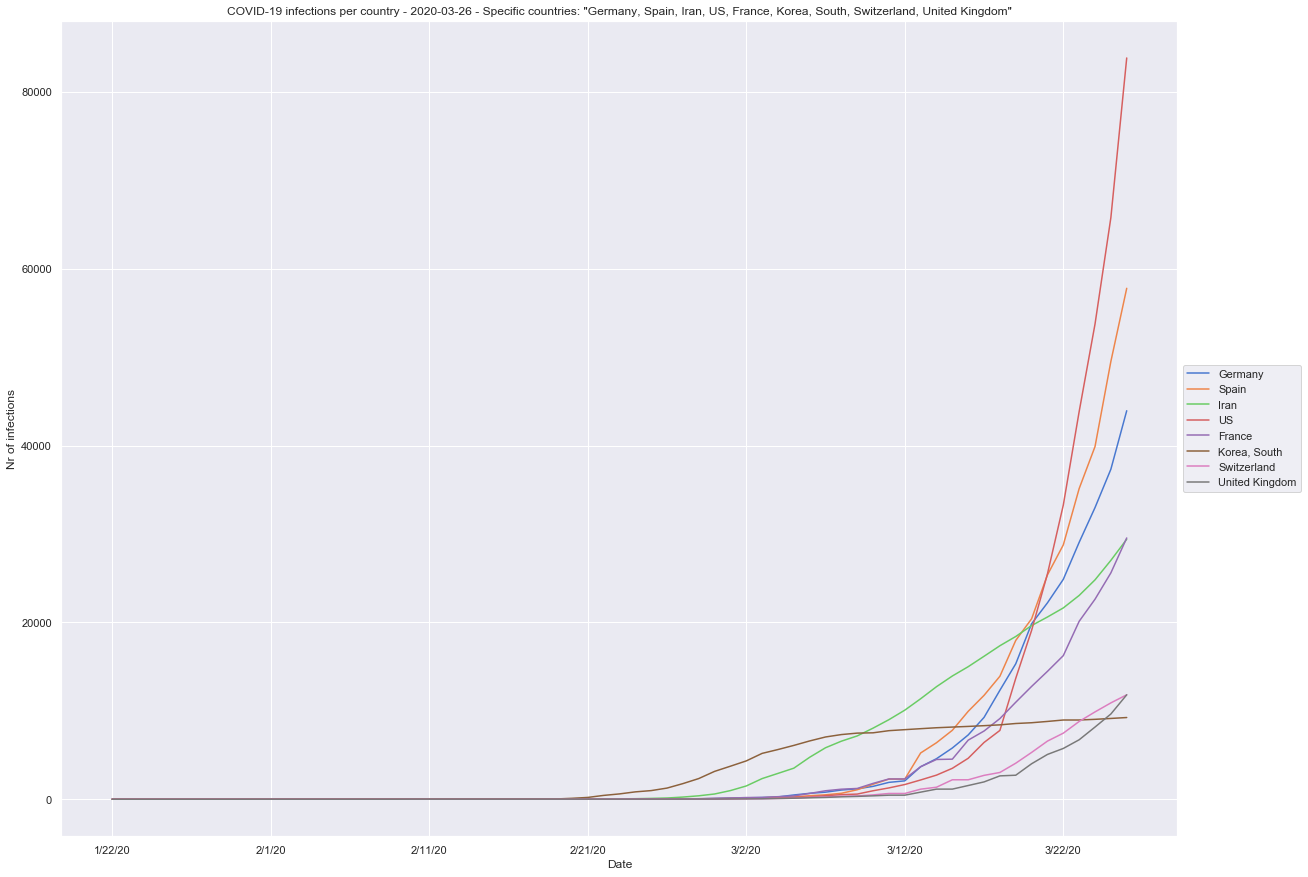

Saving plot to "C:\Users\deme\Code\py\COVID-19-Infections-Per-Country\images\2020-03-26\Specific-Countries-Germany-Spain-Iran-US-France-Korea-South-Switzerland-UnitedKingdom.png"


In [10]:
# Plot: Specific countries

plot_name = 'Specific countries: "{}"'.format(', '.join(PLOT_COUNTRIES))

if FORCE_PLOT or PLOT_SPECIFIC_COUNTRIES:
    logging.info('Plotting "{}"'.format(plot_name))

    all_countries = list(df_grouped_summed['Country/Region'])
    countries = PLOT_COUNTRIES

    # Plot
    fig, ax = plt.subplots(figsize=PLOT_SIZE)

    for cr in countries:
        if cr in all_countries:
            df_tmp = df_grouped_summed[df_grouped_summed['Country/Region']==cr]
            # Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
            df_melted = df_tmp.melt(id_vars=df_tmp.columns.values[:1], var_name='Date', value_name='Value')
            df_melted.plot(kind='line', x='Date', y='Value', ax=ax, label=cr)
        else:
            logging.info('Could not find given country "{}"'.format(cr))

    ax.set_title('{} - {} - {}'.format(PLOT_TITLE, date_last.date(), plot_name), loc='center')
    ax.set_xlabel(PLOT_LABEL_X)
    ax.set_ylabel(PLOT_LABEL_Y)

    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    plt.show()

    if FORCE_SAVE_PLOT_TO_FILE or PLOT_SPECIFIC_COUNTRIES_SAVE_PLOT_TO_FILE:
        save_plot(fig, PLOT_IMAGE_PATH, date_last, 'Specific-Countries-{}.png'.format('-'.join(PLOT_COUNTRIES)))

    plt.close(fig)

Plotting "10 Countries with highest infection rates"


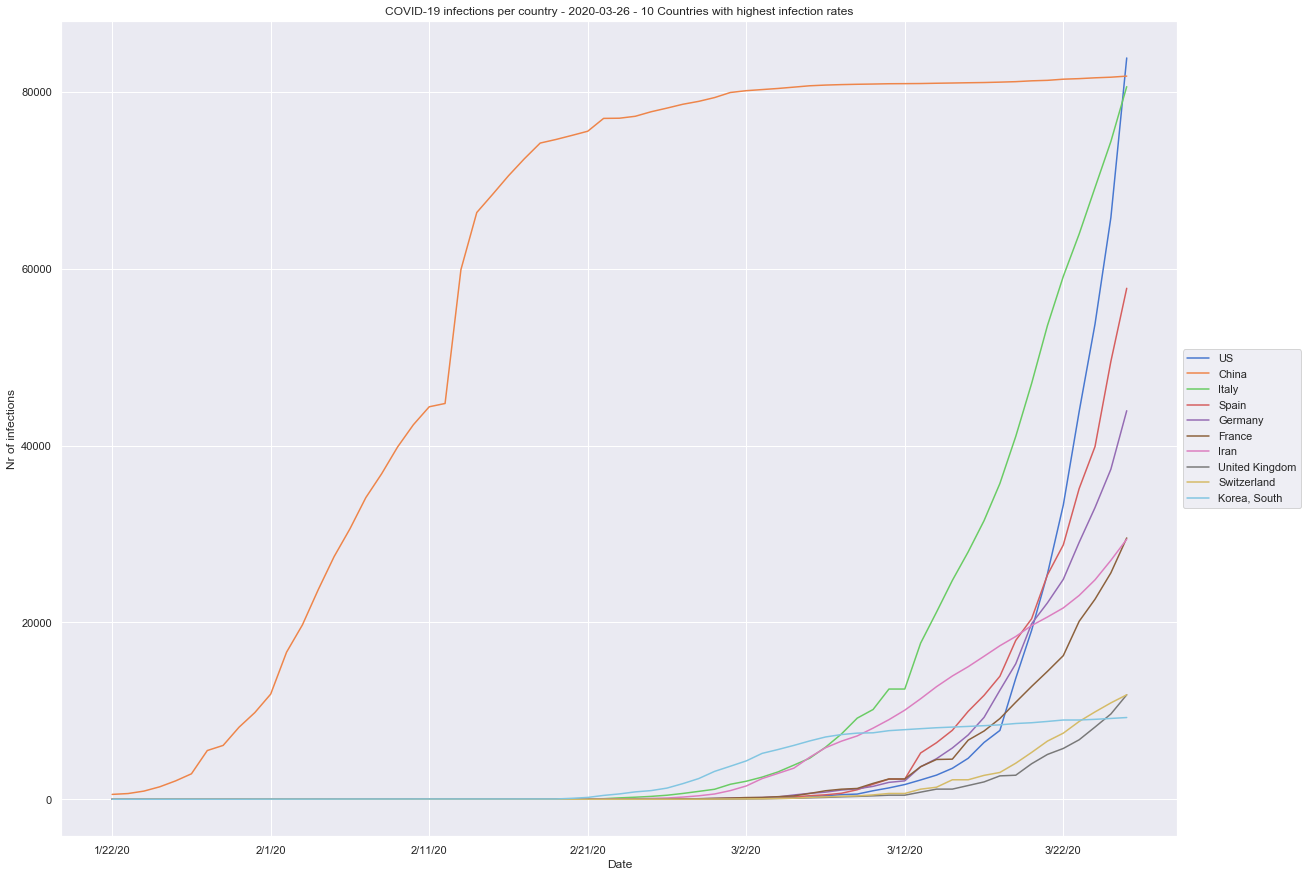

Saving plot to "C:\Users\deme\Code\py\COVID-19-Infections-Per-Country\images\2020-03-26\10-Countries-with-highest-infection-rates.png"


In [11]:
# Plot: Countries with highest infection rates

plot_name = '{} Countries with highest infection rates'.format(NR_OF_HIGHEST_COUNTRIES)

if FORCE_PLOT or PLOT_HIGHEST_COUNTRIES:
    logging.info('Plotting "{}"'.format(plot_name))
    
    # Calculate the n highest countries
    dict_highest_all = {}
    countries = df_grouped_summed['Country/Region']
    for cr in countries:
        df_tmp = df_grouped_summed[df_grouped_summed['Country/Region']==cr]
        # Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
        df_melted = df_tmp.melt(id_vars=df_tmp.columns.values[:1], var_name='Date', value_name='Value')
        dict_highest_all[cr] = df_melted.max().Value

    # Extract the n highest country names
    countries = nlargest(NR_OF_HIGHEST_COUNTRIES, dict_highest_all, key=dict_highest_all.get)

    # Plot
    fig, ax = plt.subplots(figsize=PLOT_SIZE)

    for cr in countries:
        df_tmp = df_grouped_summed[df_grouped_summed['Country/Region']==cr]
        # Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
        df_melted = df_tmp.melt(id_vars=df_tmp.columns.values[:1], var_name='Date', value_name='Value')
        df_melted.plot(kind='line', x='Date', y='Value', ax=ax, label=cr)

    ax.set_title('{} - {} - {}'.format(PLOT_TITLE, date_last.date(), plot_name), loc='center')
    ax.set_xlabel(PLOT_LABEL_X)
    ax.set_ylabel(PLOT_LABEL_Y)

    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

    if FORCE_SAVE_PLOT_TO_FILE or PLOT_HIGHEST_COUNTRIES_SAVE_PLOT_TO_FILE:
        save_plot(fig, PLOT_IMAGE_PATH, date_last, '{}-Countries-with-highest-infection-rates.png'.format(NR_OF_HIGHEST_COUNTRIES))

    plt.close(fig)

Plotting "Curve fit for country "Germany""
Fitting to days [52, 58]
Plotting to days [40, 65]


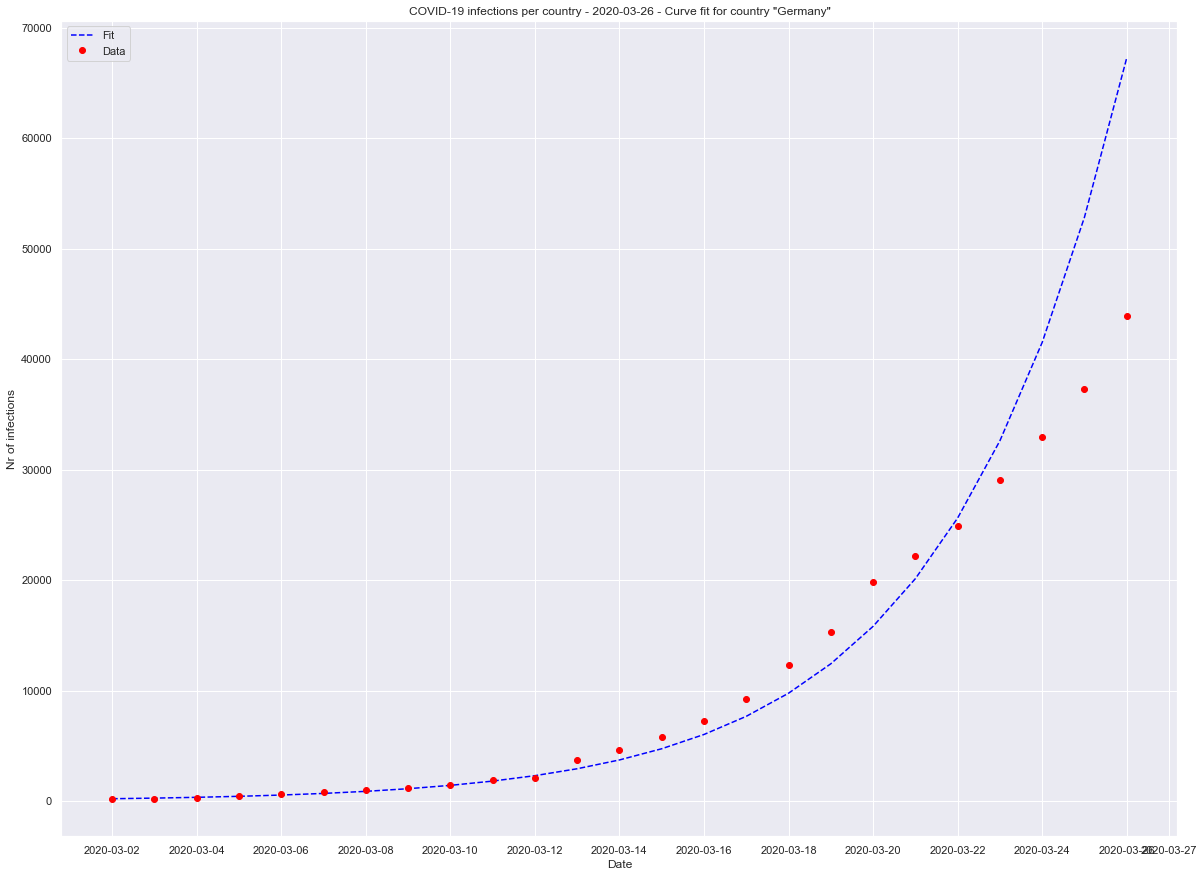

Saving plot to "C:\Users\deme\Code\py\COVID-19-Infections-Per-Country\images\2020-03-26\Curve-Fit-Germany.png"


In [12]:
# Curve fit

plot_name = 'Curve fit for country "{}"'.format(CURVE_FIT_COUNTRY)

if FORCE_PLOT or PLOT_CURVE_FIT:
    logging.info('Plotting "{}"'.format(plot_name))

    all_countries = list(df_grouped_summed['Country/Region'])
    if CURVE_FIT_COUNTRY in all_countries:
        fig, ax = plt.subplots(figsize=PLOT_SIZE)
        df_tmp = df_grouped_summed[df_grouped_summed['Country/Region']==CURVE_FIT_COUNTRY]
        # Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
        df_melted = df_tmp.melt(id_vars=df_tmp.columns.values[:1], var_name='Date', value_name='Value')

        # Validate start and end days
        day_end = len(df_melted.Value)
        day_start = 0
        if not CURVE_FIT_PLOT_RAW_DATA_ONLY:
            day_end = CURVE_FIT_END_DAY if (CURVE_FIT_END_DAY > 0 and CURVE_FIT_END_DAY < len(df_melted.Value)) else len(df_melted.Value)
            day_start = CURVE_FIT_START_DAY if CURVE_FIT_START_DAY > 0 and CURVE_FIT_START_DAY < day_end else 0
            logging.info('Fitting to days [{}, {}]'.format(day_start, day_end))
        # Validate plot start and end days
        plot_day_end = CURVE_FIT_PLOT_END_DAY if (CURVE_FIT_PLOT_END_DAY > 0 and CURVE_FIT_PLOT_END_DAY < len(df_melted.Value)) else len(df_melted.Value)
        plot_day_start = CURVE_FIT_PLOT_START_DAY if CURVE_FIT_PLOT_START_DAY > 0 and CURVE_FIT_PLOT_START_DAY < plot_day_end else 0
        logging.info('Plotting to days [{}, {}]'.format(plot_day_start, plot_day_end))

        vals_x = np.linspace(0, len(df_melted.Value), num = len(df_melted.Value))[day_start:day_end]
        vals_y = list(df_melted.Value)[day_start:day_end]
        vals_sigma = [func_sigma(y) for y in vals_y]

        vals_x_to_end = [t for t in range(plot_day_start, plot_day_end)]
        vals_y_to_end = list(df_melted.Value)[plot_day_start:plot_day_end]

        if not CURVE_FIT_PLOT_RAW_DATA_ONLY:
            # Scipy curve fit
            try:
                params, params_cov = scipy.optimize.curve_fit(func_fit, xdata=vals_x, ydata=vals_y, sigma=vals_sigma)
                vals_y_fit = [func_fit(x, params[0], params[1]) for x in vals_x_to_end]
                plt.plot(vals_x_to_end, vals_y_fit, '--', color ='blue', label ='Fit')
            except:
                logging.info('Could not find curve fit')
        else:
            logging.info('Just logging data')
        plt.plot(vals_x_to_end, vals_y_to_end, 'o', color ='red', label ='Data') 
        ax.set_title('{} - {} - {}'.format(PLOT_TITLE, date_last.date(), plot_name), loc='center')
        ax.set_xlabel(PLOT_LABEL_X)
        ax.set_ylabel(PLOT_LABEL_Y)

        # Calculate ticks and labels (=the dates on the x-axis)
        ticks = [t for t in range(plot_day_start, plot_day_end)][::2]
        if plot_day_end not in ticks and len(ticks) % 2 == 0:
            ticks = ticks + [plot_day_end]
        if CURVE_FIT_PLOT_DAYS_AS_X_LABEL:
            labels = [d for d in ticks]
        else:
            labels = [str((date_first + datetime.timedelta(days=d)).date()) for d in ticks]
        plt.xticks(ticks=ticks, labels=labels)

        plt.legend(loc='upper left')
        plt.show()

        if FORCE_SAVE_PLOT_TO_FILE or PLOT_CURVE_FIT_SAVE_PLOT_TO_FILE:
            save_plot(fig, PLOT_IMAGE_PATH, date_last, 'Curve-Fit-{}.png'.format(CURVE_FIT_COUNTRY))

        plt.close(fig)
    else:
        logging.info('Could not find given country "{}"'.format(CURVE_FIT_COUNTRY))

Plotting "Curve fit for countries "Italy, US, Spain, Germany""
Preparing country "Italy"
Fitting to days [51, 60]
Plotting to days [40, 65]
Preparing country "US"
Fitting to days [50, 59]
Plotting to days [40, 65]
Preparing country "Spain"
Fitting to days [51, 59]
Plotting to days [40, 65]
Preparing country "Germany"
Fitting to days [52, 58]
Plotting to days [40, 65]


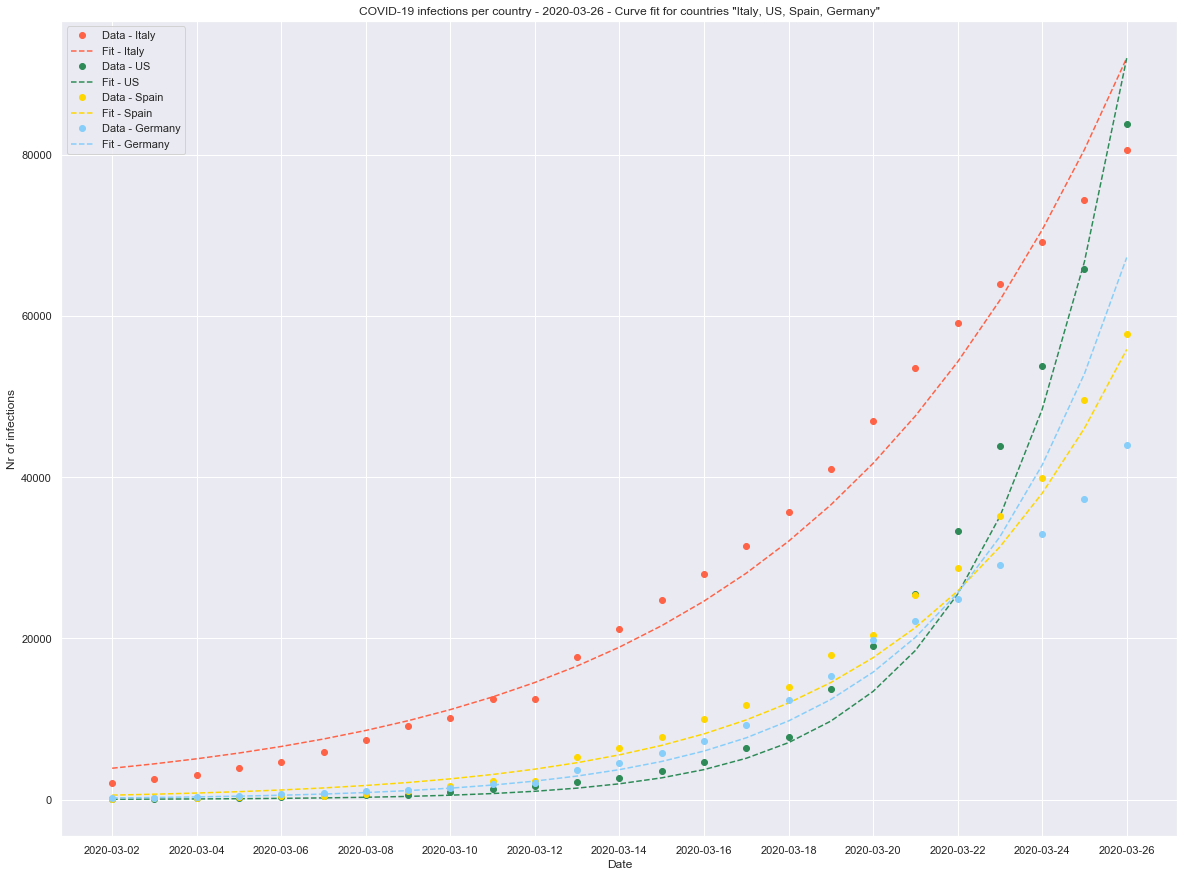

Saving plot to "C:\Users\deme\Code\py\COVID-19-Infections-Per-Country\images\2020-03-26\Curve-Fit-Italy-US-Spain-Germany.png"


In [13]:
# Curve fit multiple countries

countries = [x['name'] for x in CURVE_FIT_MULTI_COUNTRIES]
plot_name = 'Curve fit for countries "{}"'.format(', '.join(countries))

if FORCE_PLOT or PLOT_CURVE_FIT_MULTI:
    logging.info('Plotting "{}"'.format(plot_name))

    fig, ax = plt.subplots(figsize=PLOT_SIZE)

    all_countries = list(df_grouped_summed['Country/Region'])

    for country in CURVE_FIT_MULTI_COUNTRIES:
        logging.info('Preparing country "{}"'.format(country['name']))
        country_name = country['name']
        # Check best fit data for start and end day
        start_day = country['start_day']
        end_day = country['end_day']

        if country_name in all_countries:
            df_tmp = df_grouped_summed[df_grouped_summed['Country/Region']==country_name]
            # Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
            df_melted = df_tmp.melt(id_vars=df_tmp.columns.values[:1], var_name='Date', value_name='Value')

            # Validate start and end days
            day_end = len(df_melted.Value)
            day_start = 0
            if not CURVE_FIT_PLOT_RAW_DATA_ONLY:
                day_end = end_day if (end_day > 0 and end_day < len(df_melted.Value)) else len(df_melted.Value)
                day_start = start_day if start_day > 0 and start_day < day_end else 0
                logging.info('Fitting to days [{}, {}]'.format(day_start, day_end))
            # Validate plot start and end days
            plot_day_end = CURVE_FIT_MULTI_PLOT_END_DAY if (CURVE_FIT_MULTI_PLOT_END_DAY > 0 and CURVE_FIT_MULTI_PLOT_END_DAY < len(df_melted.Value)) else len(df_melted.Value)
            plot_day_start = CURVE_FIT_MULTI_PLOT_START_DAY if CURVE_FIT_MULTI_PLOT_START_DAY > 0 and CURVE_FIT_MULTI_PLOT_START_DAY < plot_day_end else 0
            logging.info('Plotting to days [{}, {}]'.format(plot_day_start, plot_day_end))

            vals_x = np.linspace(0, len(df_melted.Value), num = len(df_melted.Value))[day_start:day_end]
            vals_y = list(df_melted.Value)[day_start:day_end]
            vals_sigma = [func_sigma(y) for y in vals_y]

            vals_x_to_end = [t for t in range(plot_day_start, plot_day_end)]
            vals_y_to_end = list(df_melted.Value)[plot_day_start:plot_day_end]

            ax.plot(vals_x_to_end, vals_y_to_end, 'o', color=country['color'], label='Data - {}'.format(country_name))
            if not CURVE_FIT_PLOT_RAW_DATA_ONLY:
                # Scipy curve fit
                try:
                    params, params_cov = scipy.optimize.curve_fit(func_fit, xdata=vals_x, ydata=vals_y, sigma=vals_sigma)
                    vals_y_fit = [func_fit(x, params[0], params[1]) for x in vals_x_to_end]
                    ax.plot(vals_x_to_end, vals_y_fit, '--', color=country['color'], label='Fit - {}'.format(country_name))
                except:
                    logging.info('Could not find curve fit')
            else:
                logging.info('Just logging data')
        else:
            logging.info('Could not find given country "{}"'.format(country_name))

    ax.set_title('{} - {} - {}'.format(PLOT_TITLE, date_last.date(), plot_name), loc='center')
    ax.set_xlabel(PLOT_LABEL_X)
    ax.set_ylabel(PLOT_LABEL_Y)

    # Calculate ticks and labels (=the dates on the x-axis)
    ticks = [t for t in range(plot_day_start, plot_day_end)][::2]
    if plot_day_end not in ticks and len(ticks) % 2 == 0:
        ticks = ticks + [plot_day_end]
    if CURVE_FIT_PLOT_DAYS_AS_X_LABEL:
        labels = [d for d in ticks]
    else:
        labels = [str((date_first + datetime.timedelta(days=d)).date()) for d in ticks]
    plt.xticks(ticks=ticks, labels=labels)

    plt.legend(loc='upper left')
    plt.show()

    if FORCE_SAVE_PLOT_TO_FILE or PLOT_CURVE_FIT_MULTI_SAVE_PLOT_TO_FILE:
        save_plot(fig, PLOT_IMAGE_PATH, date_last, 'Curve-Fit-{}.png'.format('-'.join(countries)))

    plt.close(fig)